In [182]:
import numpy as np
import copy
import matplotlib.pyplot as plt
from matplotlib.cm import get_cmap

import scipy
from scipy import signal,stats
from scipy.fft import rfft,rfftfreq
from scipy import stats
from scipy.ndimage import uniform_filter1d

import seaborn as sns
import pandas as pd
import sklearn
import seaborn as sns
import os
import re

In [ ]:
# Data Loading Functions

def load_openbci_data(file_path, channel=0):
    data_file = pd.read_csv(file_path, comment='%', header=0, delimiter=',', engine='python')
    channels = [' EXG Channel 0', ' EXG Channel 1', ' EXG Channel 2', ' EXG Channel 3']
    data = data_file[channels[channel]].values
    return data

def load_awear_data(file_path):
    data_file = pd.read_csv(file_path, header=None, delimiter=',')
    brainwave_data = data_file.iloc[:, 3].values
    timestamps = data_file.iloc[:, 4].values
    return brainwave_data, timestamps

# New functions to apply a segment
def apply_segment(data, segment, fs):
    """Apply a time window segment to the data with support for negative time values."""
    if segment is None:
        return data  # No segment specified, return full data

    total_samples = len(data)
    total_duration = total_samples / fs

    # Convert start and end times to sample indices
    start, end = segment

    if start < 0:  # Negative start time means counting from the end
        start_sample = max(total_samples + int(start * fs), 0)
    else:
        start_sample = min(int(start * fs), total_samples)

    if end <= 0:  # End of 0 or negative means relative to the end
        end_sample = max(total_samples + int(end * fs), 0)
    else:
        end_sample = min(int(end * fs), total_samples)

    # Ensure valid segment indices
    if start_sample >= end_sample:
        raise ValueError(f"Invalid segment: start={start}s, end={end}s, data length={total_duration:.2f}s")

    # Return the segmented data
    return data[start_sample:end_sample]

def load_awear_data_with_segment(file_path, segment, fs):
    """Load Awear data and apply the specified segment."""
    data_file = pd.read_csv(file_path, header=None, delimiter=',')
    brainwave_data = data_file.iloc[:, 3].values  # Only extract the data column
    return apply_segment(brainwave_data, segment, fs)

# Preprocessing Functions
def butter_bandpass_filter(data, lowcut, highcut, fs, order=4):
    nyquist = 0.5 * fs
    low, high = lowcut / nyquist, highcut / nyquist
    b, a = signal.butter(order, [low, high], btype='band')
    return signal.filtfilt(b, a, data, axis=-1)

def notch_filter(data, freq, fs, Q=10):
    nyquist = 0.5 * fs
    w0 = freq / nyquist
    b, a = signal.iirnotch(w0, Q)
    return signal.filtfilt(b, a, data, axis=-1)

def apply_filters(data, fs):
    data = butter_bandpass_filter(data, 0.5, 54, fs)
    data = notch_filter(data, 50, fs)
    data = notch_filter(data, 60, fs)
    return data

# Feature Extraction and Plotting Functions
def generate_colors(num_colors):
    base_colors = ['royalblue', 'crimson', 'green', 'orange'] 
    if num_colors > len(base_colors):
        colors = [base_colors[i % len(base_colors)] for i in range(num_colors)]
    else:
        colors = base_colors[:num_colors]

    return colors

def plot_combined_psd(data_dict, fs, y_axis_limits=None):
    colors = generate_colors(len(data_dict))
    plt.figure(figsize=(8, 4))
    for idx, (file, (data, _)) in enumerate(data_dict.items()):
        freqs, psd = signal.welch(data, fs, nperseg=int(fs * 3), noverlap=int(fs * 0.50), window='hann')
        plt.semilogy(freqs, psd, linewidth=1.5, label=f'{file.capitalize()}',color=colors[idx])
    plt.title('Power Spectral Density Comparison')
    plt.xlabel('Frequency (Hz)')
    plt.ylabel('Power')
    plt.xlim([0, 80])
    if y_axis_limits:
        plt.ylim(y_axis_limits)
    plt.grid(True, which='major', linestyle='--', linewidth=0.5)
    plt.legend(loc='upper right')
    plt.tight_layout()
    plt.show()

def calculate_ratios(data_dict, fs):
    ratios = {}
    for file, (data, _) in data_dict.items():
        freqs, psd = signal.welch(data, fs, nperseg=int(fs), noverlap=int(fs * 0.50), window='hann')
        delta_power = np.sum(psd[(freqs >= 0.5) & (freqs <= 4)])
        gamma1_power = np.sum(psd[(freqs >= 30) & (freqs <= 38)])
        gamma2_power = np.sum(psd[(freqs >= 38) & (freqs <= 46)])
        gamma1_ratio = gamma1_power / delta_power if delta_power != 0 else 0
        gamma2_ratio = gamma2_power / delta_power if delta_power != 0 else 0
        ratios[file] = (gamma1_ratio, gamma2_ratio)
    return ratios

def plot_ratios_bar(ratios, y_axis_limits=None):
    files = list(ratios.keys())
    colors = generate_colors(len(files))
    gamma1_ratios = [ratios[file][0] for file in files]
    gamma2_ratios = [ratios[file][1] for file in files]
    plt.figure(figsize=(8, 4))
    plt.bar(np.arange(len(files)) - 0.175, gamma1_ratios, 0.35, label='Gamma1/Delta Ratio', color='royalblue')
    plt.bar(np.arange(len(files)) + 0.175, gamma2_ratios, 0.35, label='Gamma2/Delta Ratio', color='orange')
    plt.ylabel('Ratio (Log Scale)')
    plt.title('Gamma1/Delta and Gamma2/Delta Ratios Comparison')
    if y_axis_limits:
        plt.ylim(y_axis_limits)
    plt.yscale('log')
    plt.grid(axis='y', linestyle='--', linewidth=0.5)
    plt.xticks(np.arange(len(files)), [file.capitalize() for file in files])
    plt.legend()
    plt.tight_layout()
    plt.show()

def plot_time_frequency(data_dict, fs, vmax=None):
    fig, axes = plt.subplots(len(data_dict), 1, figsize=(10, 8))
    fig.suptitle('Time-Frequency Domain Plots for Each Dataset')
    for idx, (file, (data, _)) in enumerate(data_dict.items()):
        f, t, Sxx = signal.spectrogram(data, fs, nperseg=int(fs), noverlap=int(fs * 0.50), window='hann')
        im = axes[idx].pcolormesh(t, f, Sxx, shading='auto', cmap='viridis', vmax=vmax, vmin=0)
        axes[idx].set_title(f'{file.capitalize()}')
        axes[idx].set_ylabel('Frequency (Hz)')
        axes[idx].set_xlabel('Time (s)')
        axes[idx].set_xlim([0, len(data) / fs])
        axes[idx].set_ylim([0, 50])  
        fig.colorbar(im, ax=axes[idx], orientation='vertical', label='Power')
    plt.tight_layout()
    plt.show()

def plot_gamma_delta_ratios_spectrogram(data_dict, fs, y_axis_limits=None):
    colors = generate_colors(len(data_dict))
    freq_ranges = {'delta': (0.5, 4), 'gamma1': (30, 38), 'gamma2': (38, 46)}
    fig, (ax1, ax2) = plt.subplots(2, 1, figsize=(10, 6))
    fig.suptitle('Gamma1/Delta and Gamma2/Delta Ratios Over Time')

    for idx, (file, (data, _)) in enumerate(data_dict.items()):
        f, t, spg = signal.spectrogram(data, fs, nperseg=int(fs), noverlap=int(fs * 0.50), window='hann')
        band_powers = {band: spg[(f >= f_min) & (f <= f_max)].mean(axis=0) for band, (f_min, f_max) in freq_ranges.items()}
        gamma1_delta_ratio = np.maximum(band_powers['gamma1'] / band_powers['delta'], 1e-6)
        gamma2_delta_ratio = np.maximum(band_powers['gamma2'] / band_powers['delta'], 1e-6)

        ax1.plot(t, gamma1_delta_ratio, label=f'{file.capitalize()}', alpha=0.8, color=colors[idx])
        ax2.plot(t, gamma2_delta_ratio, label=f'{file.capitalize()}', alpha=0.8, color=colors[idx])

    ax1.set_title('Gamma1/Delta Ratio Over Time')
    ax1.set_xlabel('Time (s)')
    ax1.set_ylabel('Ratio (Log Scale)')
    ax1.set_xlim([0,None])
    if y_axis_limits:
        ax1.set_ylim(y_axis_limits)
    ax1.set_yscale('log')
    ax1.grid(True, linestyle='--')

    ax2.set_title('Gamma2/Delta Ratio Over Time')
    ax2.set_xlabel('Time (s)')
    ax2.set_ylabel('Ratio (Log Scale)')
    ax2.set_xlim([0,None])
    if y_axis_limits:
        ax2.set_ylim(y_axis_limits)
    ax2.set_yscale('log')
    ax2.grid(True, linestyle='--')

    handles, labels = ax1.get_legend_handles_labels()
    fig.legend(handles, labels, loc='center right', bbox_to_anchor=(1.05, 0.5))
    plt.tight_layout(rect=[0, 0, 0.9, 0.94])
    plt.show()

def plot_gamma_delta_ratios_box_with_mean(data_dict, fs, y_axis_limits=None):
    colors = generate_colors(len(data_dict))
    freq_ranges = {'delta': (0.5, 4), 'gamma1': (30, 38), 'gamma2': (38, 46)}
    all_gamma1_delta_ratios, all_gamma2_delta_ratios, dataset_labels = [], [], []

    for file, (data, _) in data_dict.items():
        f, t, spg = signal.spectrogram(data, fs, nperseg=int(fs), noverlap=int(fs * 0.50), window='hann')
        band_powers = {band: spg[(f >= f_min) & (f <= f_max)].mean(axis=0) for band, (f_min, f_max) in freq_ranges.items()}
        all_gamma1_delta_ratios.append(np.maximum(band_powers['gamma1'] / band_powers['delta'], 1e-6))
        all_gamma2_delta_ratios.append(np.maximum(band_powers['gamma2'] / band_powers['delta'], 1e-6))
        dataset_labels.append(file.capitalize())

    fig, axes = plt.subplots(1, 2, figsize=(10,6))
    # Gamma1/Delta Plot
    bp1 = axes[0].boxplot(all_gamma1_delta_ratios, patch_artist=True, tick_labels=dataset_labels,widths=0.5)
    for patch, color in zip(bp1['boxes'], colors):
        patch.set(facecolor=color, alpha=0.6)
    axes[0].set_title('Gamma1/Delta Ratio Across Datasets')
    axes[0].set_yscale('log')
    if y_axis_limits:
        axes[0].set_ylim(y_axis_limits)
    axes[0].grid(True, linestyle='--',alpha=0.6)
     # Add scatter points for all data points
    for i, ratios in enumerate(all_gamma1_delta_ratios):
        axes[0].scatter(
            [i + 1] * len(ratios), ratios, color='black', alpha=0.6, s=30, edgecolors='white'
        )

    # Gamma2/Delta Plot
    bp2 = axes[1].boxplot(all_gamma2_delta_ratios, patch_artist=True, tick_labels=dataset_labels,widths=0.5)
    for patch, color in zip(bp2['boxes'], colors):
        patch.set(facecolor=color, alpha=0.6)
    axes[1].set_title('Gamma2/Delta Ratio Across Datasets')
    axes[1].set_yscale('log')
    if y_axis_limits:
        axes[1].set_ylim(y_axis_limits)
    axes[1].grid(True, linestyle='--')
    # Add scatter points for all data points
    for i, ratios in enumerate(all_gamma2_delta_ratios):
        axes[1].scatter(
            [i + 1] * len(ratios), ratios, color='black', alpha=0.6, s=30, edgecolors='white'
        )

    plt.tight_layout()
    plt.show()

def apply_lzc_to_data(data_dict):
    def calculate_lzc(data):
        binary_seq = (data > np.median(data)).astype(int)
        binary_str = ''.join(binary_seq.astype(str))
        n, i, k, lzc_count = len(binary_str), 0, 1, 1

        while i + k < n:
            if binary_str[:i + k].find(binary_str[i:i + k + 1]) != -1:
                k += 1
            else:
                lzc_count += 1
                i += k
                k = 1

        norm_factor = n / np.log2(n) if n > 1 else 1
        return lzc_count / norm_factor

    return {file: calculate_lzc(data) for file, (data, _) in data_dict.items()}

def plot_lzc_values(lzc_results):
    colors = generate_colors(len(lzc_results))
    activities = list(lzc_results.keys())
    lzc_values = list(lzc_results.values())
    plt.figure(figsize=(8, 5))
    plt.bar(activities, lzc_values, color=colors, edgecolor='black')
    plt.ylabel('LZC Value')
    plt.title('LZC Values for Different Activities')
    plt.ylim(0, 1)
    for i, value in enumerate(lzc_values):
        plt.text(i, value + 0.02, f'{value:.4f}', ha='center', va='bottom', fontweight='bold')
    plt.tight_layout()
    plt.show()

# Full Pipeline Execution
def run_pipeline(data_type, file_paths, config):
    data_dict = {}
    segments = config.get('data_segments', {})
    labels = config.get('dataset_labels', {})
    fs = config.get('fs', 256)

    for file_path in file_paths:
        segment = segments.get(file_path, None)
        label = labels.get(file_path, os.path.basename(file_path).split('.')[0])  # Default to filename if no label

        # Load and apply segment to the data
        if data_type == 'openbci':
            data = load_openbci_data(file_path, config['channel'])
            data_dict[label] = (apply_segment(data, segment, fs), None)
        elif data_type == 'awear':
            data = load_awear_data_with_segment(file_path, segment, fs)
            data_dict[label] = (data, None)

    # Apply filters to the segmented data
    data_filt = {key: (apply_filters(data, fs), None) for key, (data, _) in data_dict.items()}

    # Continue with plotting and feature extraction
    if config['plots'].get('psd', True):
        plot_combined_psd(data_filt, fs, config['y_axis_limits'].get('psd'))
    if config['plots'].get('bar_ratios', True):
        ratios = calculate_ratios(data_filt, fs)
        plot_ratios_bar(ratios, config['y_axis_limits'].get('bar_ratios'))
    if config['plots'].get('time_frequency', True):
        plot_time_frequency(data_filt, fs, config.get('stft_power_scale'))
    if config['plots'].get('band_ratios_over_time', True):
        plot_gamma_delta_ratios_spectrogram(data_filt, fs, config['y_axis_limits'].get('band_ratios_over_time'))
    if config['plots'].get('box_plot', True):
        plot_gamma_delta_ratios_box_with_mean(data_filt, fs, config['y_axis_limits'].get('box_plot'))
    if config['plots'].get('lzc', True):
        lzc_results = apply_lzc_to_data(data_filt)
        plot_lzc_values(lzc_results)

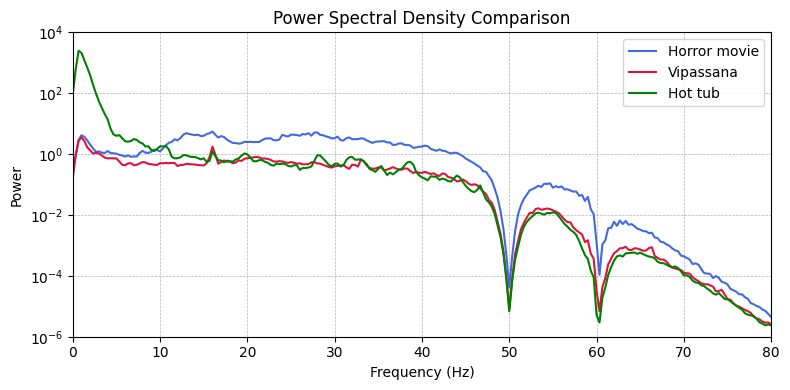

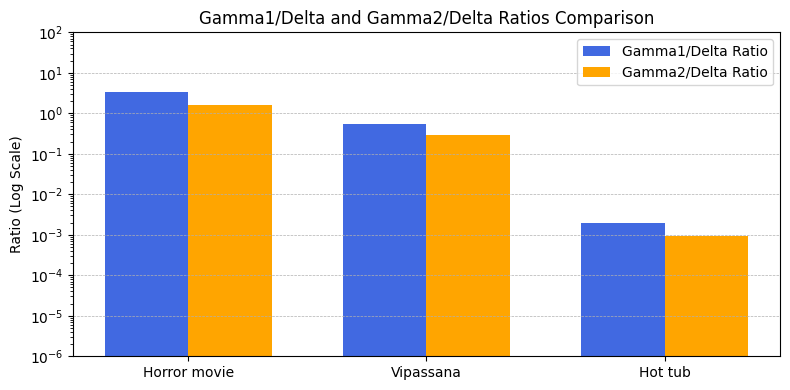

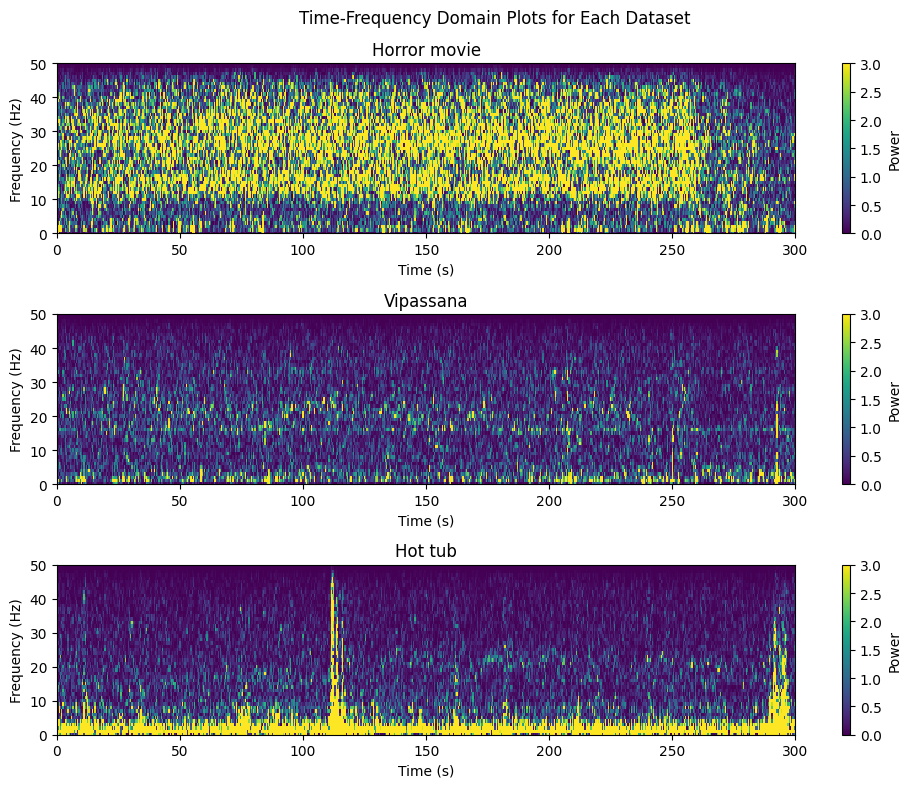

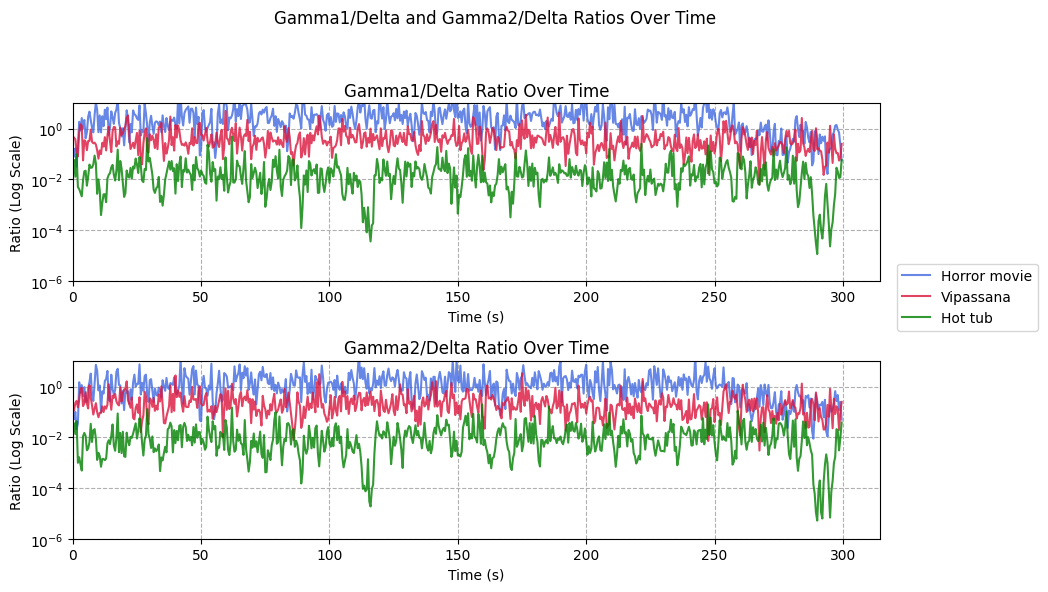

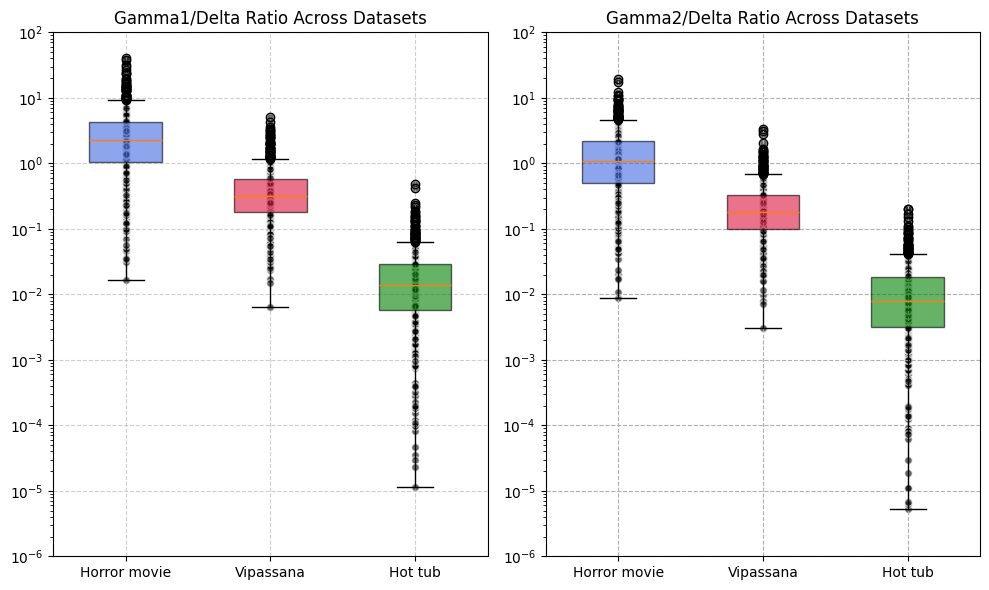

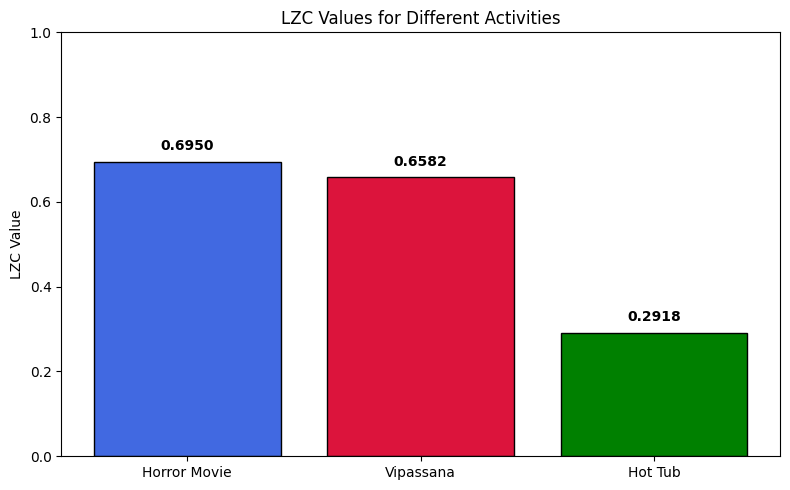

In [ ]:
# Create file paths for each dataset
file_paths = [
    '.../1_250124_205115-210602_brainwaves - Antonio - LVHA - Horror movies.txt',
    '.../2_250124_210834-212527_brainwaves - Antonio - HVLA - Vipassana.txt',
    '.../3_250124_225258-230511_brainwaves - Antonio - HVLA - Vipassana after hot tub.txt'
]

# Set labels 
custom_labels = [
    "Horror Movie",
    "Vipassana",
    "Hot Tub"
]

# Select sections of data you are interested in
custom_segments = [
    (120, 420),   
    (-300, 0),   
    (-300, 0)    
]

# Automatically generate config dictionaries
config = {
    'fs': 256,
    'plots': {
        'psd': True,
        'bar_ratios': True,
        'time_frequency': True,
        'band_ratios_over_time': True,
        'box_plot': True,
        'lzc': True
    },
    'channel': 0,
    'y_axis_limits': {
        'psd': [1e-6, 1e4],
        'bar_ratios': [1e-6, 1e2],
        'band_ratios_over_time': [1e-6, 10],
        'box_plot': [1e-6, 1e2]
    },
    'stft_power_scale': 3,
    'data_segments': {file: segment for file, segment in zip(file_paths, custom_segments)},
    'dataset_labels': {file: label for file, label in zip(file_paths, custom_labels)}
}

# Run the pipeline
run_pipeline(data_type='awear', file_paths=file_paths, config=config)

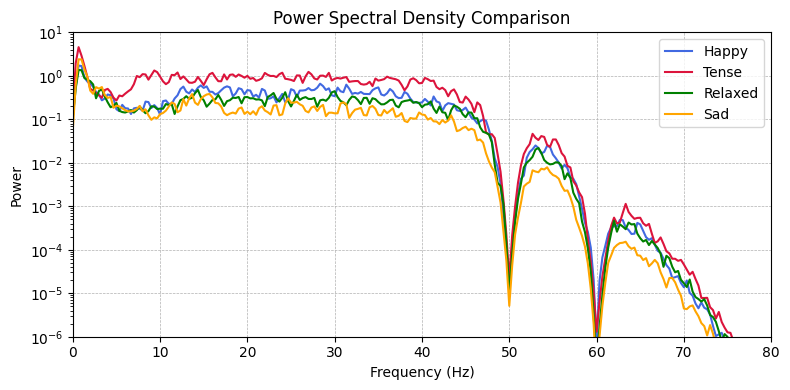

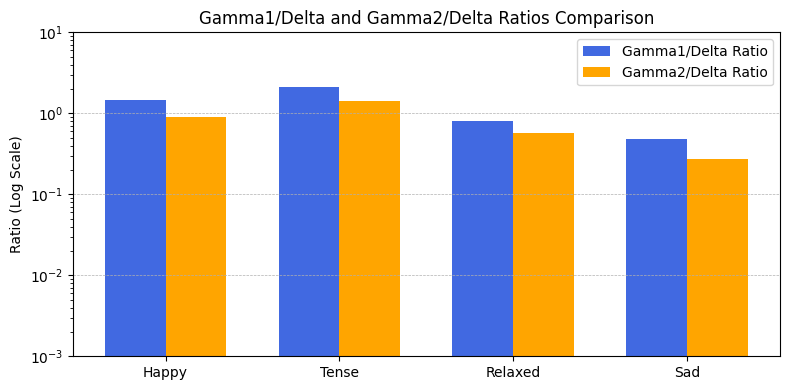

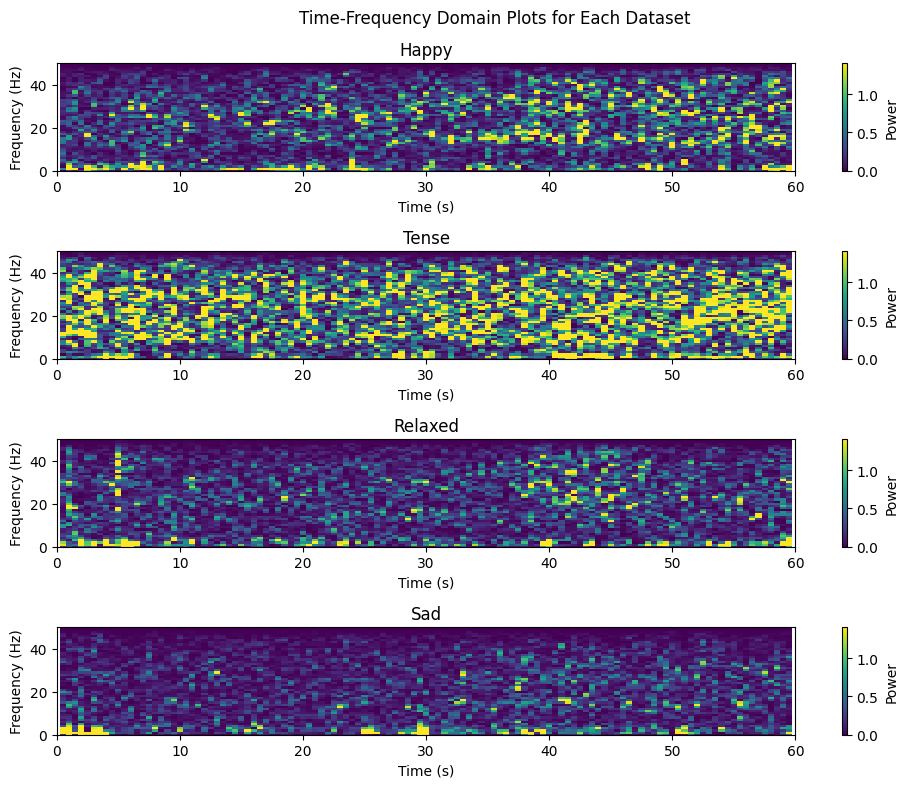

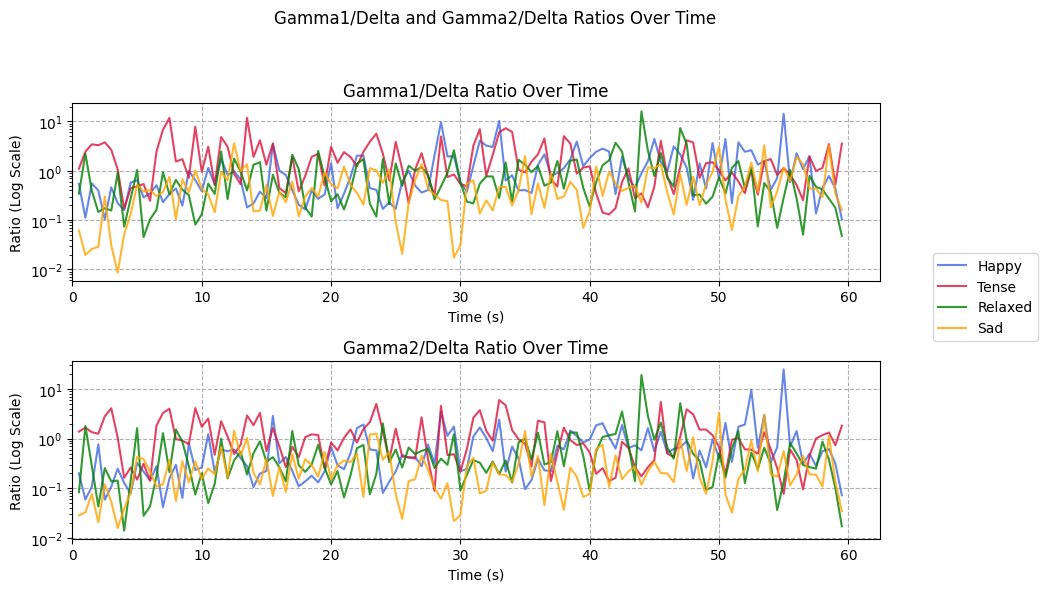

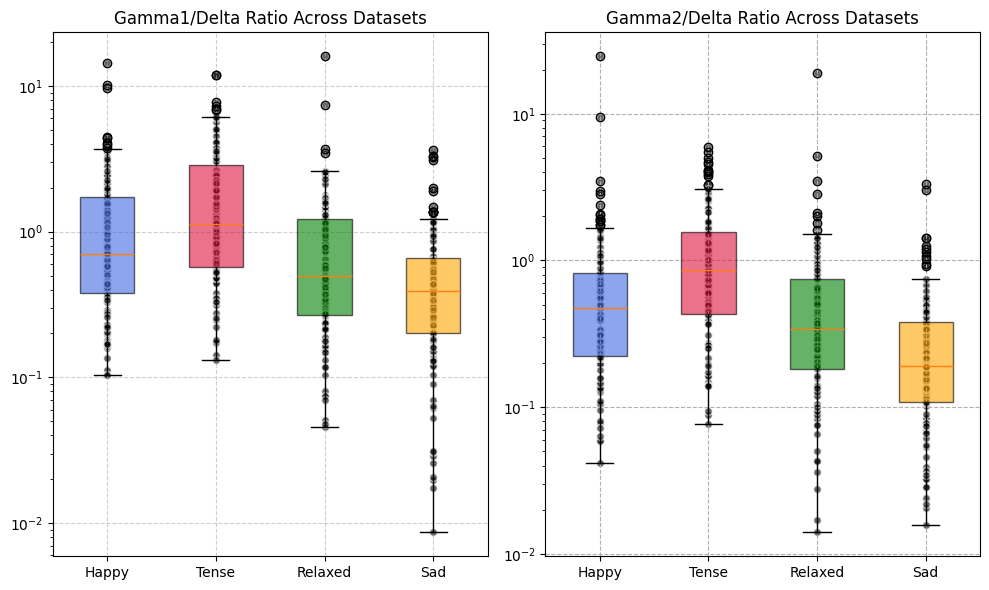

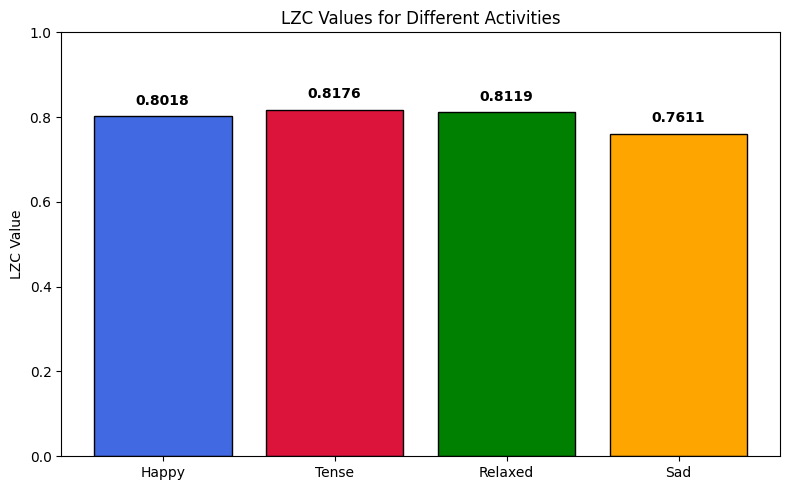

In [ ]:
# Define the paths to the EEG data files
file_paths = [
    '.../Subject 3 Antonio/Erotic_5.txt',
    '.../Subject 3 Antonio/Fear 2_1.txt',
    '.../Subject 3 Antonio/Scenery_2.txt',
    '.../Subject 3 Antonio/Sadness_7.txt'
]

# Set labels 
custom_labels = [
    "Happy",
    "Tense",
    "Relaxed",
    "Sad"
]

# Select sections of data you are interested in
custom_segments = [
    (60,120),   
    (60,120),   
    (60,120),
    (60,120)    
]

# Automatically generate config dictionaries
config = {
    'fs': 200,
    'plots': {
        'psd': True,
        'bar_ratios': True,
        'time_frequency': True,
        'band_ratios_over_time': True,
        'box_plot': True,
        'lzc': True
    },
    'channel': 0,
    'y_axis_limits': {
        'psd': [1e-6, 1e1],
        'bar_ratios': [1e-3, 1e1],
        'band_ratios_over_time': None, #[1e-6, 10],
        'box_plot': None #[1e-6, 1e2]
    },
    'stft_power_scale': 1.4,
    'data_segments': {file: segment for file, segment in zip(file_paths, custom_segments)},
    'dataset_labels': {file: label for file, label in zip(file_paths, custom_labels)}
}

# Run the pipeline
run_pipeline(data_type='openbci', file_paths=file_paths, config=config)
